In [19]:
import pandas as pd 
from pandas import Series
import numpy as np 
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm
from statsmodels.api import OLS
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.graphics.api import qqplot  
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson


from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX 

import pmdarima as pm
from pmdarima import auto_arima 
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import nsdiffs
from statsmodels.tsa.seasonal import seasonal_decompose 
from sklearn import datasets

# Ignore harmless warnings 
import warnings 
warnings.filterwarnings("ignore") 

In [20]:
#Importing data
Shenyang = pd.read_csv("D:/Math546 Time series/final projects/PM2.5 Data of Five Chinese Cities Data Set/ShenyangPM20100101_20151231.csv")

In [21]:
#Delet non-useful data
##Beijing.drop(['PM_Dongsi', 'PM_Dongsihuan', 'PM_Nongzhanguan', 'season', 'precipitation', 'Iprec'], 
##               axis=1,
##              inplace=True)

In [22]:
Shenyang.dropna(axis=0, how="any",inplace=True)

In [27]:
# from datetime import datetime
Shenyang['Time'] = pd.to_datetime(Shenyang['year'].map(str) +"/"+ Shenyang['month'].map(str) +"/"+ Shenyang['day'].map(str)+" "+Shenyang['hour'].map(str)+":00:00")
#Shenyang

In [28]:
Shenyang.groupby(['year']).size()

year
2013    4416
2014    7447
2015    7175
dtype: int64

In [30]:
by_hour = Shenyang.groupby(['Time']).mean()
#print(by_hour.head())

In [31]:
by_hour.index = pd.to_datetime(by_hour.index, 
                             format='%d-%m-%Y %H:%M:%S')
by_hour = by_hour.set_index(by_hour.index).asfreq('H')
by_hour = by_hour.fillna(method='ffill')

#print(by_hour.index)

In [34]:
by_hour['Time'] = by_hour.index
#by_hour['Time']

In [35]:
data_13 = by_hour[(by_hour['Time'] >=pd.to_datetime('20140101030000')) & (by_hour['Time'] <= pd.to_datetime('20151231030000'))]

In [36]:
data_13 = data_13.set_index(data_13.index).asfreq('d')
data_13 = data_13.fillna(method='ffill')

In [37]:
#data_13.to_csv(r'D:/Math546 Time series/project/Prep_FiveCitiePMData_MEAN/ShenyangPM_cleaned.csv')

In [41]:
data = by_hour[(by_hour['Time'] >=pd.to_datetime('20140101030000')) & (by_hour['Time'] <= pd.to_datetime('20140201030000'))]
data = data.set_index(data.index).asfreq('d')
data = data.fillna(method='ffill')
#data

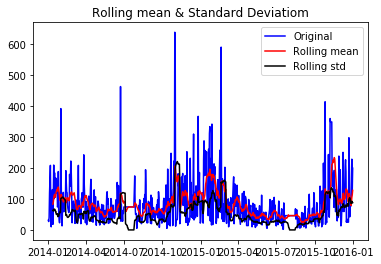

Resluts of Dickey-Fuller Test:
Test Statistic               -5.836380e+00
p-value                       3.867822e-07
#lags used                    7.000000e+00
Number of obervations used    7.220000e+02
Critical Value(1%)           -3.439440e+00
Critical Value(5%)           -2.865551e+00
Critical Value(10%)          -2.568906e+00
dtype: float64


In [42]:
# take aDFuller test the statioinarity of  the timeseries
def test_stationarity(timeseries):
 #Determing rolling statistics
    rolmean=pd.Series.rolling(timeseries,window=12).mean()
 #rolmean=pd.rolling_mean(timeseries,window=12)
 #rolstd=pd.rolling_std(timeseries,window=12)
    rolstd=pd.Series.rolling(timeseries,window=12).std()
 
 #plot rolling statistics
    orig=plt.plot(timeseries,color='blue',label='Original')
    mean=plt.plot(rolmean,color='red',label='Rolling mean')
    std=plt.plot(rolstd,color='black',label='Rolling std')
    plt.legend(loc='best')
    plt.title('Rolling mean & Standard Deviatiom')
    plt.show(block=False)
 
 #perfprmance Dickey_Fuller Test
    print('Resluts of Dickey-Fuller Test:')
    dftest=adfuller(timeseries,autolag='AIC')
    dfountput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','Number of obervations used'])
 
    for key,value in dftest[4].items():
        dfountput['Critical Value(%s)'%key]=value      
    print(dfountput)
# 

test_stationarity(data_13['PM_US Post'])

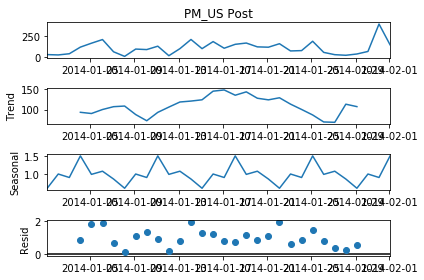

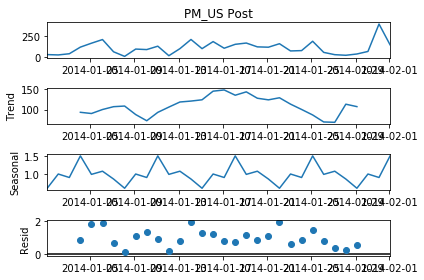

In [43]:
result = seasonal_decompose(data['PM_US Post'],  
                            model ='multiplicative') 
  
# ETS plot  
result.plot()

In [44]:
len(data_13)

730

In [45]:
# Split data into train / test sets 
train = data_13['PM_US Post'].iloc[:len(data_13)-156] 
test = data_13['PM_US Post'].iloc[len(data_13)-156:]

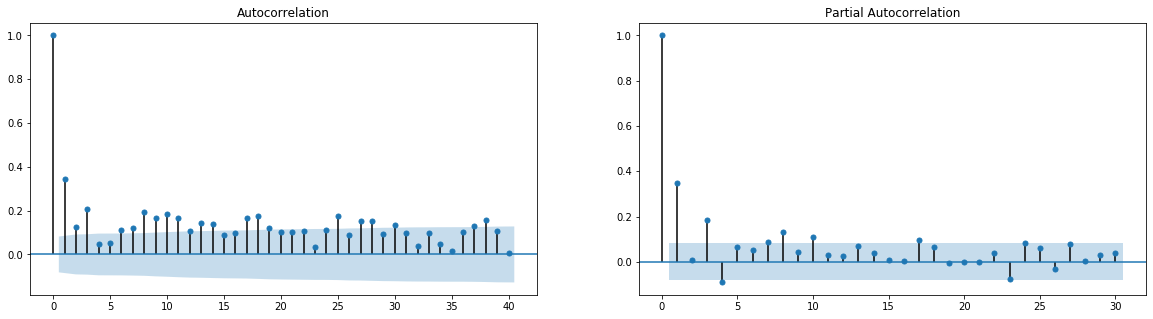

In [46]:
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

fig, axes = plt.subplots(1,2, figsize=(20,5))
plot_acf(train, lags=40, ax=axes[0], fft=False)
plot_pacf(train, lags=30, ax=axes[1])
plt.show()

In [50]:
# Fit auto_arima function to dataset 
stepwise_fit = auto_arima(train, start_p = 0, start_q = 0, 
                          max_p = 3, max_q = 4, m=52,
                          start_P = 0, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)           # set to stepwise  

Performing stepwise search to minimize aic
Fit ARIMA: (0, 0, 0)x(0, 1, 1, 52) (constant=True); AIC=6079.336, BIC=6092.109, Time=14.968 seconds
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 52) (constant=True); AIC=6294.149, BIC=6302.664, Time=0.519 seconds
Fit ARIMA: (1, 0, 0)x(1, 1, 0, 52) (constant=True); AIC=6133.916, BIC=6150.947, Time=29.228 seconds
Fit ARIMA: (0, 0, 1)x(0, 1, 1, 52) (constant=True); AIC=6009.054, BIC=6026.085, Time=19.691 seconds
Near non-invertible roots for order (0, 0, 1)(0, 1, 1, 52); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 52) (constant=False); AIC=6293.864, BIC=6298.121, Time=1.536 seconds
Fit ARIMA: (0, 0, 0)x(1, 1, 1, 52) (constant=True); AIC=6078.403, BIC=6095.434, Time=36.996 seconds
Near non-invertible roots for order (0, 0, 0)(1, 1, 1, 52); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (0, 0, 0)x(0, 1, 2, 52) (cons

In [51]:
# To print the summary 
stepwise_fit.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  574
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 52)   Log Likelihood               -3000.309
Date:                              Tue, 14 Apr 2020   AIC                           6008.617
Time:                                      22:01:14   BIC                           6025.648
Sample:                                           0   HQIC                          6015.288
                                              - 574                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.3034      1.295     -1.006      0.314      -3.842       1.235
ar.L1          0.3606      0.023     15.849      0.000       0.316       0.405
ma.S.L52      -0.9994     13.666     -0.073      0.942     -27.784      25.785
sigma2      4537.3853   6.19e+04      0.073      0.942   -1.17e+05    1.26e+05
===================================================================================
Ljung-Box (Q):                      131.81   Jarque-Bera (JB):              3759.75
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.19   Skew:                             2.12
Prob(H) (two-sided):                  0.26   Kurtosis:                        15.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [52]:
# Fit a SARIMAX(1, 0, 0)x(0, 1, [1], 52)on the training set 
from statsmodels.tsa.statespace.sarimax import SARIMAX 
  
model = SARIMAX(train,  
                order = (1, 0, 0),  
                seasonal_order =(0, 1, [1], 52))

In [53]:
result = model.fit() 

In [54]:
 result.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                           PM_US Post   No. Observations:                  574
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 52)   Log Likelihood               -3001.414
Date:                              Tue, 14 Apr 2020   AIC                           6008.827
Time:                                      22:02:21   BIC                           6021.600
Sample:                                  01-01-2014   HQIC                          6013.830
                                       - 07-28-2015                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3665      0.021     17.337      0.000       0.325       0.408
ma.S.L52      -0.9871      0.569     -1.734      0.083      -2.103       0.129
sigma2      4611.4103   2515.270      1.833      0.067    -318.429    9541.249
===================================================================================
Ljung-Box (Q):                      130.33   Jarque-Bera (JB):              3711.29
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.23   Skew:                             2.10
Prob(H) (two-sided):                  0.17   Kurtosis:                        15.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

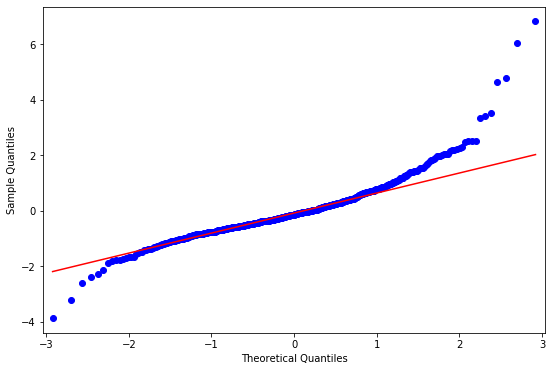

In [55]:
resid = result.resid
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
qqplot(resid, line='q', ax=ax, fit=True)
plt.show()

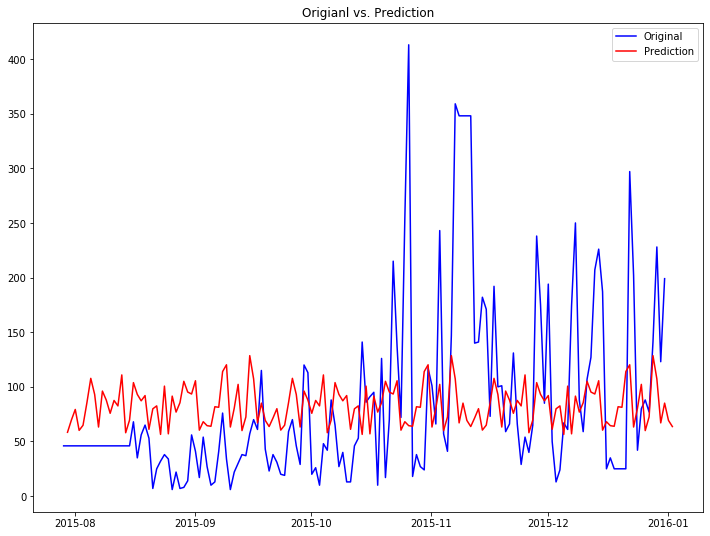

In [56]:
predict_ARMA = result.predict(start =575, end = 731) 
#print(predict_ARIMA) 

plt.figure(figsize=(12,9)) 
orig = plt.plot(test, color='blue', label='Original') 
pred = plt.plot(predict_ARMA, color='red', label='Prediction' ) 
plt.legend(loc='best') 
plt.title('Origianl vs. Prediction') 
plt.show(block=False) 